In [1]:
wav_path = "sample_callback.wav"

import numpy as np
from scipy.io import wavfile
from scipy.signal import butter, ShortTimeFFT, filtfilt
from sklearn.preprocessing import minmax_scale

import matplotlib.pyplot as plt
plt.style.use('dark_background')  # heck yeah
%matplotlib widget

%load_ext autoreload
%autoreload 1

def normalize(x, range=(-1,1)):
    flattened = minmax_scale(x.flatten(), feature_range=range).astype('float32')
    return flattened.reshape(x.shape)

fs, audio = wavfile.read(wav_path)

In [2]:
from utils.audio import AudioObject, plot_spectrogram

In [3]:
# Filter + spectrogram parameters
# 8pole butterpass bandworth filter or wtv the kids are saying these days

f_low, f_high = (500, 15000)
b, a = butter(8, [f_low, f_high], btype="bandpass", fs=fs)

n = 1024  # window length
overlap = 1020

In [4]:
bird_audio = AudioObject(
    normalize(audio[:, 0]),
    fs,
    b,
    a,
    do_spectrogram=True,
)

In [5]:
speaker_audio = AudioObject(
    normalize(audio[:, 3]),
    fs,
    b,
    a,
    do_spectrogram=True,
)

In [6]:
for x in (bird_audio.spectrogram, speaker_audio.spectrogram):
    print("Min: %.3f | Max %.3f" % (np.min(x), np.max(x)))

Min: 0.000 | Max 1.000
Min: 0.000 | Max 1.000


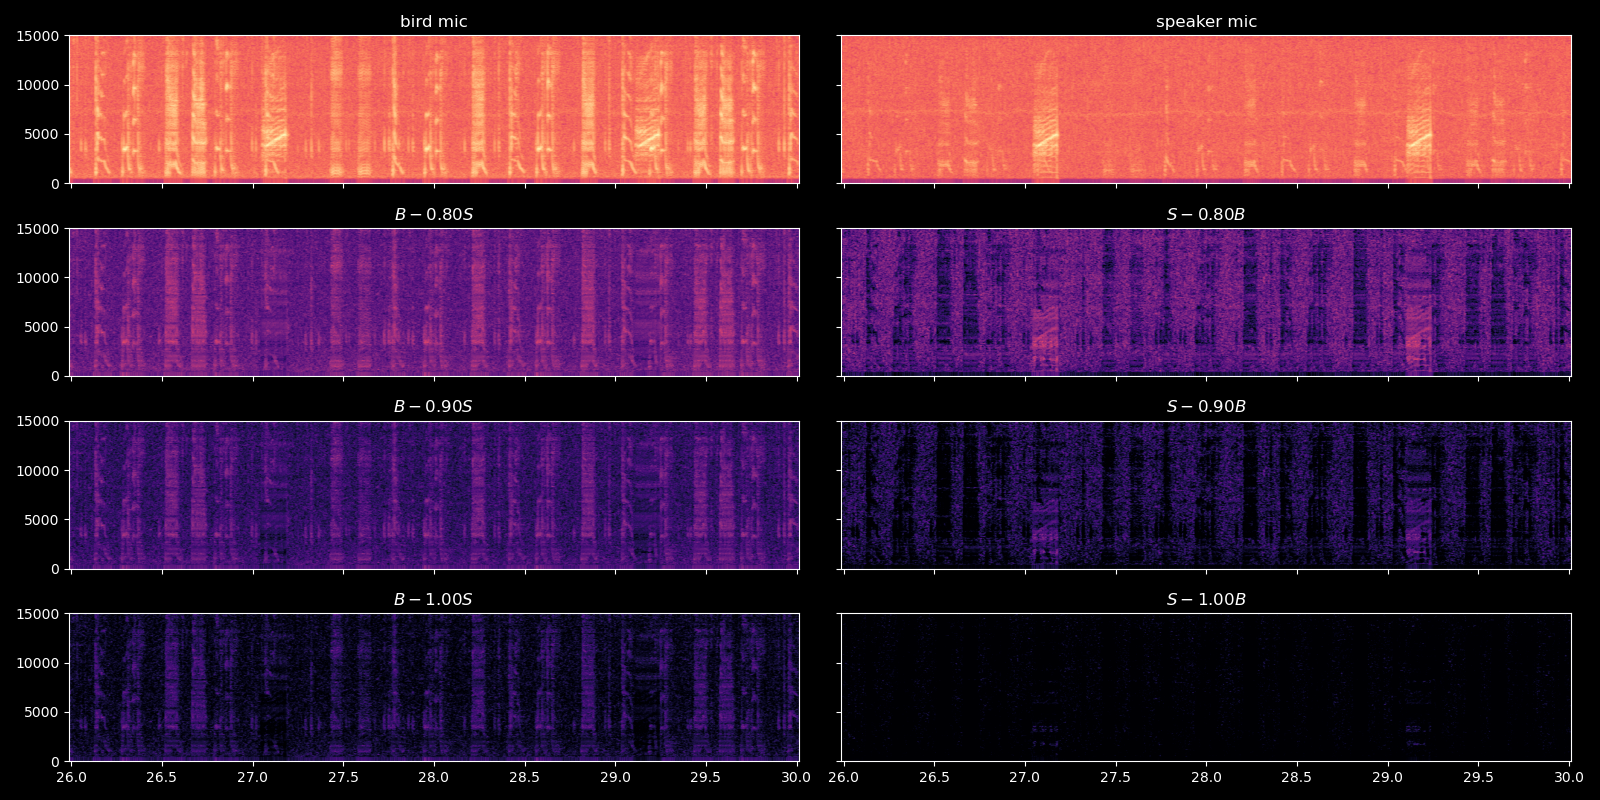

In [7]:
ks = [0.8, 0.9, 1]
# subtract = lambda x, y, k: normalize(x.spectrogram - k * y.spectrogram, range=(0, 1))
subtract = lambda x, y, k: np.maximum(x.spectrogram - k * y.spectrogram, 0)

snippet = [26, 30]  # only plot between these times (in seconds)

fig, axs = plt.subplots(
    len(ks) + 1,
    2,
    figsize=[4 * (len(ks) + 1), 8],
    sharex=True,
    sharey=True,
)
st, en = (np.array(snippet) * fs / (n - overlap)).astype("int")

to_plot = {
    "bird mic": bird_audio.spectrogram,
    "speaker mic": speaker_audio.spectrogram,
}

# subtract different multiples & store spectrograms in "to_plot"
for k in ks:
    to_plot[r"$B-%.2fS$" % (k)] = subtract(bird_audio, speaker_audio, k)
    to_plot[r"$S-%.2fB$" % (k)] = subtract(speaker_audio, bird_audio, k)

for (t, x), ax in zip(to_plot.items(), axs.ravel()):

    plot_spectrogram(
        x[:, st:en],
        bird_audio.SFT,
        ax=ax,
        x_offset_s=snippet[0],
        cmap="magma",
    )

    ax.set(
        title=t,
        xlabel=None,
        ylabel=None,
        ylim=(0, 15000),
    )

fig.tight_layout()